# Implementation of MultiLayer Perceptron from scratch

In [1]:
# Importing packages that will be used in the code.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Exploratory Data Analysis

In [2]:
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
continuous = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

df[continuous].describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [5]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

for column in categorical:
    print(f'column name - {column}', df[column].unique())

column name - sex [1 0]
column name - cp [3 2 1 0]
column name - fbs [1 0]
column name - restecg [0 1 2]
column name - exang [0 1]
column name - slope [0 2 1]
column name - ca [0 2 1 3 4]
column name - thal [1 2 3 0]


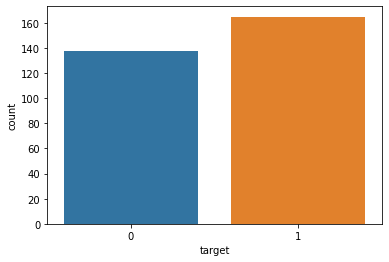

In [6]:
ax = sns.countplot(data=df, x='target')

## Summary
1. No missing values
2. There are some outliers
3. Some categorical columns have more than two (unique) values
4. Not significant disbalance in target column

# Data Preporation

## Categorical
For better performance of model, let's transform categorical columns, where more than two values, in `dummy` values.

In [7]:
cats = ['cp', 'restecg', 'slope', 'ca', 'thal']

for col in cats:
    df = df.join(pd.get_dummies(df[col], prefix=col))

df.drop(columns=cats, inplace=True)
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,1,0,...,0,1,0,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,1,0,0,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,1,0,...,1,1,0,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,1,0,...,1,1,0,0,0,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,1,1,...,1,1,0,0,0,0,0,0,1,0


## Split & Scale

In [8]:
X = df.drop('target', axis=1)
y = pd.DataFrame(df, columns=['target'])
X = X.values
y = y.values

# Splitting the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=101)

# Scale datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Multilayer Perceptron

## MLP
We implement MLP with 3 hidden layers, consisting of 10, 10 and 5 units, respectively.

In [9]:
class NeuralNetwork:
    def __init__(self, x, y, random_state=None):
        """
        Initialize the weights of the neural network

        :param x: The input to the neural network
        :param y: The output of the training data
        :param random_state: This is the seed for the random number generator
        """
        # Initializing the input and output variables.
        self.input = x
        self.y = y
        self.output = np.zeros(y.shape)

        # Set seed, and initialize the weights of the neural network.
        np.random.seed(seed=random_state)
        self.w1 = np.random.rand(self.input.shape[1], 10)
        self.w2 = np.random.rand(10, 10)
        self.w3 = np.random.rand(10, 5)
        self.w4 = np.random.rand(5, 1)

    # Create the activation functions of the sigmoid and its derivative, which we will need in the calculations
    def sigmoid(self, x):
        """
        The sigmoid function takes in a number and outputs a number between 0 and 1.

        :param x: the input data
        :return: The sigmoid function is being applied to each element of the input array.
        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        """
        The derivative of the sigmoid function is the multiplication of the input and the sigmoid function
        itself

        :param x: the input to the layer
        :return: The derivative of the sigmoid function.
        """
        return x * (1 - x)

    # The feedforward function implements a direct link from the input layer to the output layer
    def feedforward(self):
        """
        The output of the neural network is the output of the final layer
        """
        self.a1 = self.input
        self.z2 = self.a1.dot(self.w1)
        self.a2 = self.sigmoid(self.z2)

        self.z3 = self.a2.dot(self.w2)
        self.a3 = self.sigmoid(self.z3)

        self.z4 = self.a3.dot(self.w3)
        self.a4 = self.sigmoid(self.z4)

        self.z5 = self.a4.dot(self.w4)
        self.output = self.sigmoid(self.z5)

    # The backprop function implements the backpropagation algorithm
    def backprop(self):
        """
        The error is backpropagated through the network. 

        The weights are adjusted to minimize the error. 

        The error is calculated by taking the difference between the expected output and the predicted
        output.
        """
        self.output_error = self.output - self.y
        self.output_delta = self.output_error * self.sigmoid_deriv(self.output)

        self.a4_error = self.output_delta.dot(self.w4.T)
        self.a4_delta = self.a4_error * self.sigmoid_deriv(self.a4)

        self.a3_error = self.a4_delta.dot(self.w3.T)
        self.a3_delta = self.a3_error * self.sigmoid_deriv(self.a3)

        self.a2_error = self.a3_delta.dot(self.w2.T)
        self.a2_delta = self.a2_error * self.sigmoid_deriv(self.a2)

        self.w4 -= self.a4.T.dot(self.output_delta) * self.learning_rate
        self.w3 -= self.a3.T.dot(self.a4_delta) * self.learning_rate
        self.w2 -= self.a2.T.dot(self.a3_delta) * self.learning_rate
        self.w1 -= self.a1.T.dot(self.a2_delta) * self.learning_rate

    # Create functions to display the error of the network on each cycle
    def plot_train_mse(self):
        """
        It plots the MSE on the training set.
        """
        print(f'MSE on Train\n{np.round(self.errors[-1], 2)}')
        plt.plot(self.errors)
        plt.ylabel("MSE")
        plt.xlabel("Epochs")
        plt.show()

    # The train function starts the MLP training process
    def train(self, epochs=1, lr=0.01, eplot=False):
        """
        1. Feedforward the input through the network.
        2. Calculate the error of the output layer.
        3. Backpropagate the error.
        4. Update the weights.
        5. Repeat

        :param epochs: Number of epochs to train the model, defaults to 1 (optional)
        :param lr: learning rate
        :param eplot: Plot the error after each epoch, defaults to False (optional)
        """
        self.learning_rate = lr

        self.errors = []

        for e in range(1, epochs + 1):
            # Training model
            self.feedforward()
            self.backprop()

            # Metrics
            self.errors.append(np.mean(np.square(self.output_error)))
            self.accuracy.append(accuracy_score(self.y, np.round(self.output)))

        if eplot:
            self.plot_train_mse()

    def predict(self, x):
        """
        Given a set of inputs, the network will predict the output

        :param x: The input to the network
        """
        self.input = x
        self.feedforward()

    def evaluate(self, y, threshold=0.5):
        """
        It prints out the confusion matrix and classification report.

        :param y: The actual labels
        :param threshold: The threshold value for the model to consider a prediction as 1
        """
        self.y = y
        print(
            f'Confusion Matrix\n{confusion_matrix(self.y, np.where(self.output > threshold, 1, 0))}\n')
        print(
            f'Classification Report\n{classification_report(self.y, np.where(self.output > threshold, 1, 0))}')

### Training

MSE on Train
0.03


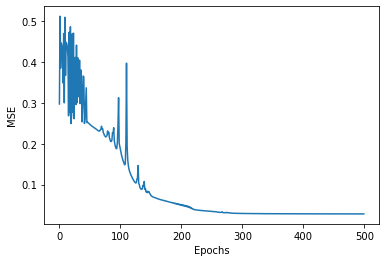

In [10]:
NN = NeuralNetwork(X_train, y_train, random_state=248)
NN.train(epochs=500, lr=0.1, eplot=True)

### Testing

In [11]:
NN.predict(X_test)
NN.evaluate(y_test)

Confusion Matrix
[[24  4]
 [ 5 28]]

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.88      0.85      0.86        33

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



# Logistic Regression
Let's compare our model to Logistic Regression (sklearn)

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=248).fit(X_train, y_train.ravel())

cm = confusion_matrix(y_test, clf.predict(X_test))
cr = classification_report(y_test, clf.predict(X_test))

print('Confusion Matrix for Logistic Regression:''\n', cm)
print("\nClassification Report for Logistic Regression:""\n", cr)

Confusion Matrix for Logistic Regression:
 [[25  3]
 [ 6 27]]

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        28
           1       0.90      0.82      0.86        33

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

